# Distributed Inference

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import os, sys, subprocess
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

import ot

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc s

In [3]:
import matplotlib.pylab as pl

In [4]:
sys.path.append('../')
sys.path.append('../..')
from src.generate_data import generate_data_from_signal, generate_grouped_data, generate_series, sample_prior, generate_theta, generate_alternate_series
from src.posterior_samplers import posterior_sample, wasserstein_coefs, normal_sampler, make_1D_trunc_gauss

## Generate Data

In [5]:
# Params
n=4800
m=40
sig=1
tau=1
alpha=1
beta = 1
num_coef = 1000

In [6]:
signal = generate_theta(num_coeff=num_coef)
observations = generate_grouped_data(signal, n=n, sig=sig, m=m)

In [7]:
def list_of_arrary_to_df(list_of_array, 
                         type_col='Simulated', 
                         list_index = 'index',
                         inter_list_index='observation'):
    
    all_obs = pd.DataFrame.from_records(list_of_array)
    stacked_obs = all_obs.reset_index().set_index('index').stack().reset_index()

    stacked_obs.columns = [inter_list_index, list_index, 'value']

    stacked_obs['type'] = type_col
    
    return stacked_obs

sort the thetas by component

In [8]:
list_of_theta = [observations[i] for i in range(len(observations))]
stacked_theta = list_of_arrary_to_df(list_of_theta, list_index = 'component')
theta_observations = np.array([stacked_theta.loc[stacked_theta['component'] == i,'value'] for i in range(num_coef)])

In [9]:
list_of_obs = [Y for X,Y in [generate_alternate_series(observations[i]) for i in range(len(observations))]]

In [10]:
stacked_obs = list_of_arrary_to_df(list_of_obs, list_index='time_index')

In [11]:
signal_df = pd.DataFrame({'value': generate_alternate_series(signal)[1], 'time_index' : [i for i in np.arange(len(signal))]})
signal_df['type'] = 'True'

## Visualise the data

In [12]:
plot_df = pd.concat([stacked_obs[['time_index','value', 'type']], signal_df], sort=True).reset_index()

In [13]:
plot_df['time'] = plot_df['time_index']/num_coef

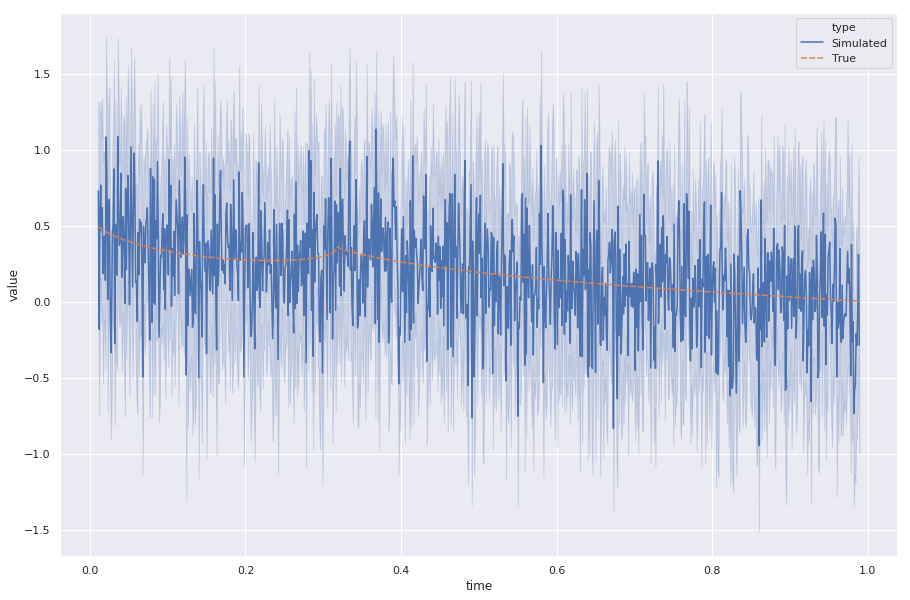

In [14]:
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
plot_df_reduced = plot_df.loc[(plot_df.time_index > 10) & (plot_df.time_index <990),:]
# Plot the responses for different events and regions
sns.lineplot(x="time", y='value', hue='type', data=plot_df_reduced, ax=ax, style='type')

## Session

In [15]:
ps_hosts=["localhost:2222"]
worker_hosts=["localhost:2223","localhost:2224"]
cluster = tf.train.ClusterSpec({"ps": ps_hosts, "worker": worker_hosts})

server = tf.train.Server(cluster,
                             job_name='ps',
                             task_index=0)

UnknownError: Could not start gRPC server

In [23]:
np.exp(4800)+np.exp(0)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


inf

# Uniform prior

In [ ]:
make_1D_trunc_gauss(lb=-0.5, )

In [16]:
a = theta_observations[0]
n_bins=100

In [53]:
hist_array= np.empty((0,n_bins))
for num in a:
    temp_hist = make_1D_trunc_gauss(n=n_bins, lb=-0.5 , n_sig = n, ub = 0.5, mu=num, sig = sig)
    hist_array = np.vstack((hist_array, temp_hist))
#hist_array = hist_array[1:,]
A = hist_array.T

In [54]:
n_distributions = A.shape[1]

In [55]:
n_distributions

40

In [59]:
x = np.arange(-0.5,0.5,1/n_bins, dtype=np.float64)

In [63]:
M = ot.utils.dist0(n_bins)

M /= M.max()

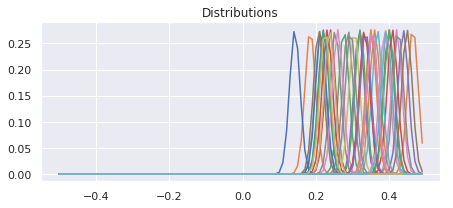

In [61]:
pl.figure(1, figsize=(6.4, 3))
for i in range(n_distributions):
    pl.plot(x, A[:, i])
pl.title('Distributions')
pl.tight_layout()

In [64]:
# wasserstein
reg = 1e-3
bary_wass = ot.bregman.barycenter(A, M, reg, weights=None)

In [65]:
bary_wass

array([9.85542438e-208, 1.07585138e-202, 1.00543879e-197, 8.14279124e-193,
       5.71485583e-188, 3.47577431e-183, 1.83194390e-178, 8.36733360e-174,
       3.31189309e-169, 1.13600396e-164, 3.37674057e-160, 8.69820936e-156,
       1.94167406e-151, 3.75609972e-147, 6.29668852e-143, 9.14748315e-139,
       1.15160976e-134, 1.25638681e-130, 1.18783389e-126, 9.73200602e-123,
       6.90976594e-119, 4.25146507e-115, 2.26687830e-111, 1.04744712e-107,
       4.19421147e-104, 1.45540160e-100, 4.37652776e-097, 1.14048831e-093,
       2.57552814e-090, 5.04029635e-087, 8.54791427e-084, 1.25625717e-080,
       1.59996788e-077, 1.76586819e-074, 1.68896098e-071, 1.39989435e-068,
       1.00550727e-065, 6.25877710e-063, 3.37604374e-060, 1.57812339e-057,
       6.39275644e-055, 2.24413859e-052, 6.82693079e-050, 1.79976432e-047,
       4.11168739e-045, 8.14027076e-043, 1.39659963e-040, 2.07643963e-038,
       2.67535246e-036, 2.98714988e-034, 2.89032936e-032, 2.42354990e-030,
       1.76104685e-028, 1

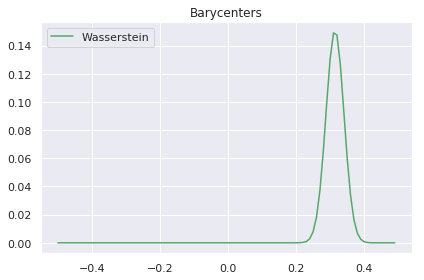

In [66]:
pl.plot(x, bary_wass, 'g', label='Wasserstein')
pl.legend()
pl.title('Barycenters')
pl.tight_layout()

## Sequential graph

In [41]:
wass_bary_temp = [wasserstein_coefs(observations[i], n, sig, alpha) for i in range(m)] 
wass_bary_coefs = np.mean(wass_bary_temp,0)
wass_bary_sample = normal_sampler(wass_bary_coefs[0,], wass_bary_coefs[1,])
wass_centred_mean = [np.square(wass_bary_temp[i][0]-wass_bary_coefs[0]) for i in range(m)]
kl_additional_variance = np.mean(wass_centred_mean,0)
kl_bary_sample = normal_sampler(wass_bary_coefs[0,], wass_bary_coefs[1,] + kl_additional_variance)

/homes/bhe/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/homes/bhe/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/homes/bhe/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/homes/bhe/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/homes/bhe/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is depreca

## Wasserstein results

In [67]:
nsim = 2000
wass_results = [None] * nsim
break_div = np.floor_divide(nsim,10)
with tf.Session() as sess: 
    for i in range(nsim):
        wass_results[i] = sess.run(wass_bary_sample)
        
        if i % break_div == 0:
            print("Iteration {0} of {1}".format(i, nsim))

Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000


### Look at Wasserstein results

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


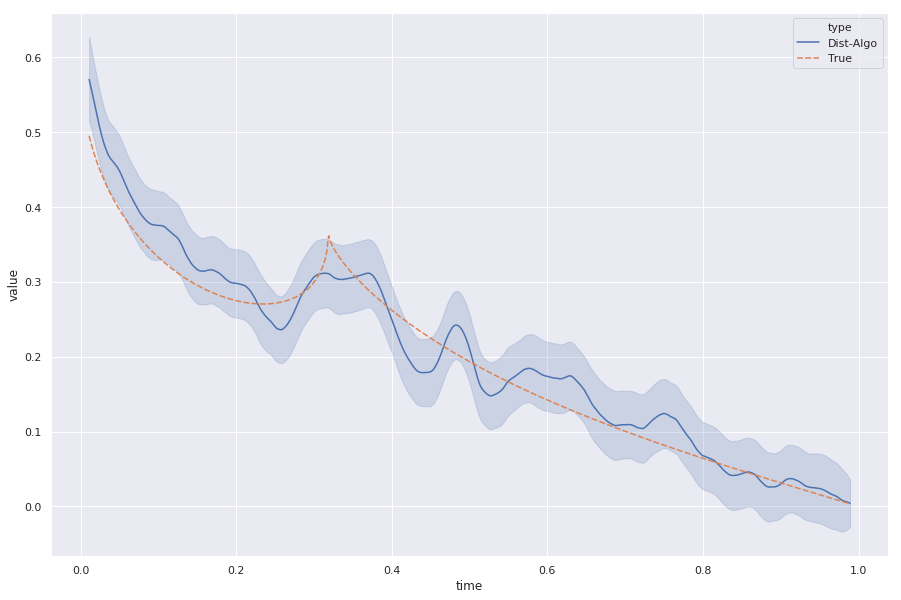

In [109]:
list_of_post = [Y for X,Y in [generate_alternate_series(wass_results[i]) for i in range(len(wass_results))]]
stacked_post = list_of_arrary_to_df(list_of_post, list_index='time_index', type_col='Dist-Algo')

plot_df2 = pd.concat([stacked_post[['time_index','value', 'type']], signal_df], sort=True)\
.reset_index()
plot_df3 = plot_df2.loc[(plot_df2.time_index > 10) & (plot_df2.time_index <990),:]
plot_df3['time'] = plot_df3['time_index']/num_coef
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)

# Plot the responses for different events and regions
sns.lineplot(x="time", y='value', hue='type', data=plot_df3, ax=ax, style='type', ci='sd')

## Results KL- barycenter

In [65]:
nsim = 2000
kl_results = [None] * nsim
break_div = np.floor_divide(nsim,10)
with tf.Session() as sess: 
    for i in range(nsim):
        kl_results[i] = sess.run(kl_bary_sample)
        
        if i % break_div == 0:
            print("Iteration {0} of {1}".format(i, nsim))

Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000


## KL Barycenter plot

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


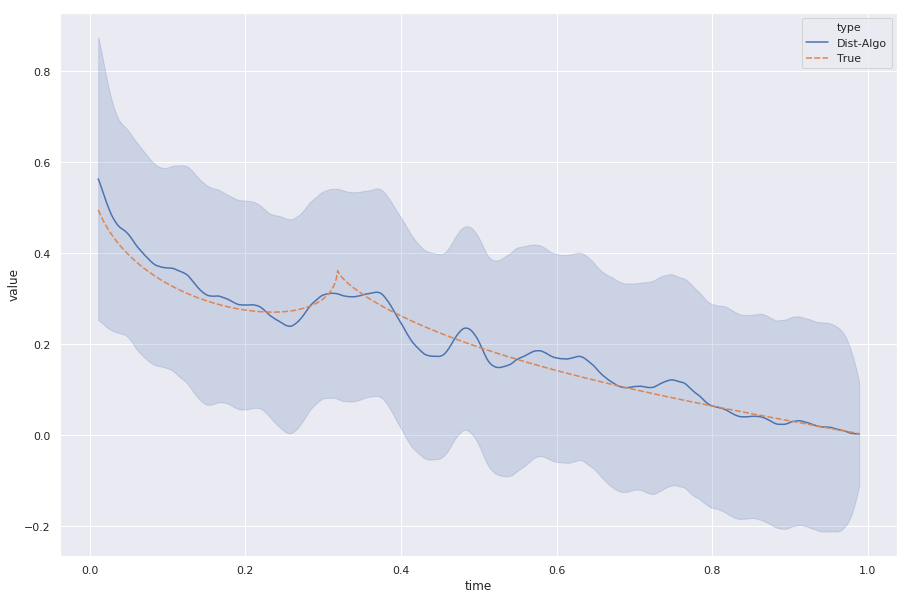

In [110]:
list_of_post = [Y for X,Y in [generate_alternate_series(kl_results[i]) for i in range(len(kl_results))]]
stacked_post = list_of_arrary_to_df(list_of_post, list_index='time_index', type_col='Dist-Algo')

plot_df2 = pd.concat([stacked_post[['time_index','value', 'type']], signal_df], sort=True)\
.reset_index()
plot_df3 = plot_df2.loc[(plot_df2.time_index > 10) & (plot_df2.time_index <990),:]
plot_df3['time'] = plot_df3['time_index']/num_coef
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)

# Plot the responses for different events and regions
sns.lineplot(x="time", y='value', hue='type', data=plot_df3, ax=ax, style='type', ci='sd')

## Build Distributed graph

First set up worker compute nodes for tasks 0,1 etc. using commands below from scripts directory in separate processes i.e. from separate terminals or as background processes:

- python create_worker.py --ps_hosts=localhost:2222 --worker_hosts=localhost:2223,localhost:2224 --job_name=worker --task_index=0 &
- python create_worker.py --ps_hosts=localhost:2222 --worker_hosts=localhost:2223,localhost:2224 --job_name=worker --task_index=1 &

Or use bash script from the scripts directory:
- sh -x bash.sh

In [35]:
ps_hosts=["localhost:2222"]
worker_hosts=["localhost:2223","localhost:2224"]
cluster = tf.train.ClusterSpec({"ps": ps_hosts, "worker": worker_hosts})

In [36]:
server = tf.train.Server(cluster,
                             job_name='ps',
                             task_index=0)

UnknownError: Could not start gRPC server

In [37]:
with tf.device("/job:worker/task:0"):
    posterior1 = posterior_sample(observations[0], n, m, sig, tau, alpha)
    
with tf.device("/job:worker/task:1"):
    posterior2 = posterior_sample(observations[1], n, m, sig, tau, alpha)

    samp = (posterior1 + posterior2)/2
    

/homes/bhe/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/homes/bhe/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/homes/bhe/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/homes/bhe/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/homes/bhe/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is depreca

In [18]:
nsim = 2000
results = [None] * nsim
break_div = np.floor_divide(nsim,10)
with tf.Session("grpc://localhost:2223") as sess: 
    for i in range(nsim):
        results[i] = sess.run(samp)
        
        if i % break_div == 0:
            print("Iteration {0} of {1}".format(i, nsim))

Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000


### Look at results

In [ ]:
list_of_post = [Y for X,Y in [generate_series(results[i]) for i in range(len(results))]]
stacked_post = list_of_arrary_to_df(list_of_post, list_index='time_index', type_col='Dist-Algo')

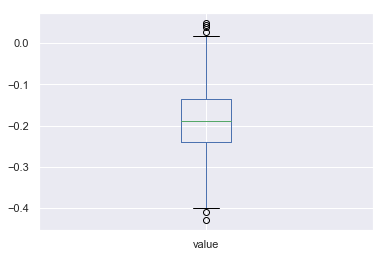

In [78]:
stacked_post.loc[stacked_post.time_index == 50,['value']].boxplot()

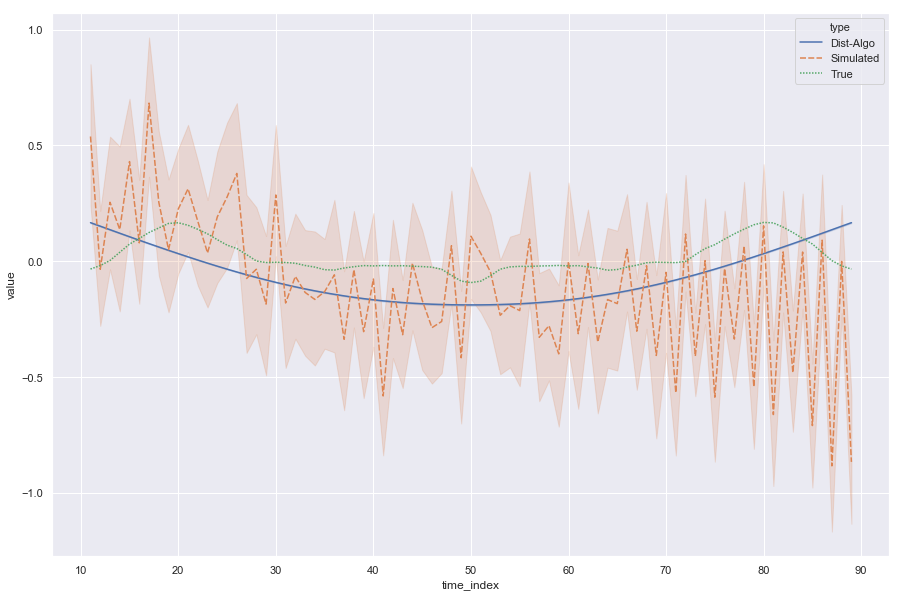

In [74]:
plot_df2 = pd.concat([stacked_post[['time_index','value', 'type']], plot_df], sort=True)\
.reset_index()

rview = (plot_df2.time_index > 10) & (plot_df2.time_index <90)# & (plot_df2.type=='Dist-Algo')
plot_df3 = plot_df2.loc[rview,:]

a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)

# Plot the responses for different events and regions
sns.lineplot(x="time_index", y='value', hue='type', data=plot_df3, ax=ax, style='type', err_style = 'band')
